In [1]:
# 2023 NOV 02

In [2]:
import sklearn
import numpy as np
import pandas as pd

# prepare data

## example #1: titanic dataset

* functions for pre-processing

In [3]:
from sklearn.preprocessing import LabelEncoder

# drop
def drop_features(df, features):
    df.drop(features, axis=1, inplace=True)
    
# encode
def encode_features(df, features):
    encoder = LabelEncoder()
    for feature in features:
        encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
        
# null
def fill_nulls(df, instructions):
    for feature, method in instructions.items():
        if method == "N":
            df[feature].fillna("N", inplace=True)
        elif method == "mean":
            df[feature].fillna(df[feature].mean(), inplace=True)
        else:
            print("<!> unknown method")
            
# combined
def preprocess_features(df, features_to_drop, instructions_to_fill_null, features_to_encode):
    drop_features(df, features_to_drop)
    fill_nulls(df, instructions_to_fill_null)
    
    print("number of nulls in dataset:", df.isnull().sum().sum())
    
    encode_features(df, features_to_encode)

* load, extract, and pre-process data

In [4]:
# read & load
titanic_df = pd.read_csv("../data/titanic_train.csv")

feature_names = ["PaxID", "Survived", "Class", "Name", "Sex", "Age", "SibSpo", "ParChi", "Ticket", "Fare", "Cabin", "PortEmba"]
titanic_df.columns = feature_names

# extract features and targets
y = titanic_df["Survived"]
X = titanic_df.drop("Survived", axis=1, inplace=False)

# pre-process
features_to_drop = ["PaxID", "Name", "Ticket"]
instructions_to_fill_null = {"Age": "mean", "Cabin": "N", "PortEmba": "N"}
features_to_encode = ["Cabin", "Sex", "PortEmba"]

preprocess_features(X, features_to_drop, instructions_to_fill_null, features_to_encode)

display(X)

number of nulls in dataset: 0


/tmp/ipykernel_10414/3260261966.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].mean(), inplace=True)
/tmp/ipykernel_10414/3260261966.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,Class,Sex,Age,SibSpo,ParChi,Fare,Cabin,PortEmba
0,3,1,22.000000,1,0,7.2500,146,3
1,1,0,38.000000,1,0,71.2833,81,0
2,3,0,26.000000,0,0,7.9250,146,3
3,1,0,35.000000,1,0,53.1000,55,3
4,3,1,35.000000,0,0,8.0500,146,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,146,3
887,1,0,19.000000,0,0,30.0000,30,3
888,3,0,29.699118,1,2,23.4500,146,3
889,1,1,26.000000,0,0,30.0000,60,0


# prepare evaluation function

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [6]:
def evaluate(y_test, predictions):
    # confusion matrix
    print("confusion matrix:\n", confusion_matrix(y_test, predictions), "\n")
    
    # accuracy, precision & recall
    print(f"accuracy : {accuracy_score(y_test, predictions):.4f}")
    print(f"precision: {precision_score(y_test, predictions):.4f}")
    print(f"recall   : {recall_score(y_test, predictions):.4f}")

# train, predict, evaluation

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


In [8]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="liblinear")

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [9]:
evaluate(y_test, predictions)

confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377


# some functions to know

* predict_proba

In [10]:
proba = classifier.predict_proba(X_test)
predi = classifier.predict(X_test)

proba_predi = np.concatenate([proba, predi.reshape(-1, 1)], axis=1)
proba_predi_df = pd.DataFrame(proba_predi, columns=["Proba(Nega)", "Proba(Posi)", "Predi"])

display(proba_predi_df)

,Proba(Nega),Proba(Posi),Predi
0,0.454763,0.545237,1.0
1,0.865475,0.134525,0.0
2,0.865499,0.134501,0.0
3,0.838322,0.161678,0.0
4,0.808816,0.191184,0.0
...,...,...,...
174,0.501967,0.498033,0.0
175,0.912299,0.087701,0.0
176,0.852038,0.147962,0.0
177,0.580810,0.419190,0.0


* Binarizer

In [11]:
from sklearn.preprocessing import Binarizer

proba_posi = proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.5)  # predict as "positive" when positive propability is >= 0.5
binarizer.fit(proba_posi)

# binarizer: predict
predi_binarizer = binarizer.transform(proba_posi)

# classifier: predict
predi_classifier = classifier.predict(X_test)

In [12]:
print("binarizer predictions:")
evaluate(y_test, predi_binarizer)

print("\n", "classifier predictions:", sep="")
evaluate(y_test, predi_classifier)

# -> therefore, classifier indeed classifies as "positive" when positive propability is >= 0.5

binarizer predictions:
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377

classifier predictions:
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377


# confidence threshold sweep

In [13]:
def evaluate_for_each_threshold(y_test, proba_posi, thresholds):
    for threshold in thresholds:
        print("threshold:", threshold)
        
        binarizer = Binarizer(threshold=threshold)
        binarizer.fit(proba_posi)
        predi_binarizer = binarizer.transform(proba_posi)
        
        evaluate(y_test, predi_binarizer)   

In [14]:
thresholds = np.arange(0.4, 0.65, 0.05)

evaluate_for_each_threshold(y_test, proba_posi, thresholds)

threshold: 0.4
confusion matrix:
 [[98 20]
 [11 50]] 

accuracy : 0.8268
precision: 0.7143
recall   : 0.8197
threshold: 0.45
confusion matrix:
 [[106  12]
 [ 14  47]] 

accuracy : 0.8547
precision: 0.7966
recall   : 0.7705
threshold: 0.5
confusion matrix:
 [[108  10]
 [ 16  45]] 

accuracy : 0.8547
precision: 0.8182
recall   : 0.7377
threshold: 0.55
confusion matrix:
 [[111   7]
 [ 17  44]] 

accuracy : 0.8659
precision: 0.8627
recall   : 0.7213
threshold: 0.6
confusion matrix:
 [[113   5]
 [ 18  43]] 

accuracy : 0.8715
precision: 0.8958
recall   : 0.7049


* precision_recall_curve()

In [15]:
from sklearn.metrics import precision_recall_curve

# get prediction probabilities for class 1 (ex. "survived")
proba_posi = classifier.predict_proba(X_test)[:, 1]

#
precisions, recalls, thresholds = precision_recall_curve(y_test, proba_posi)
# print(thresholds.shape, precisions.shape, recalls.shape)

# pick some indices 
num_thresholds = thresholds.shape[0];
indices = np.arange(0, num_thresholds, num_thresholds//10)

# print
print("thresholds:", np.round(thresholds[indices], 2))
print("precisions:", np.round(precisions[indices], 2))
print("recalls   :", np.round(recalls[indices], 2))

thresholds: [0.02 0.11 0.13 0.15 0.19 0.28 0.4  0.52 0.65 0.79 0.92]
precisions: [0.34 0.37 0.42 0.45 0.52 0.63 0.7  0.82 0.95 0.95 1.  ]
recalls   : [1.   1.   0.97 0.9  0.9  0.9  0.82 0.74 0.59 0.34 0.08]


* plot

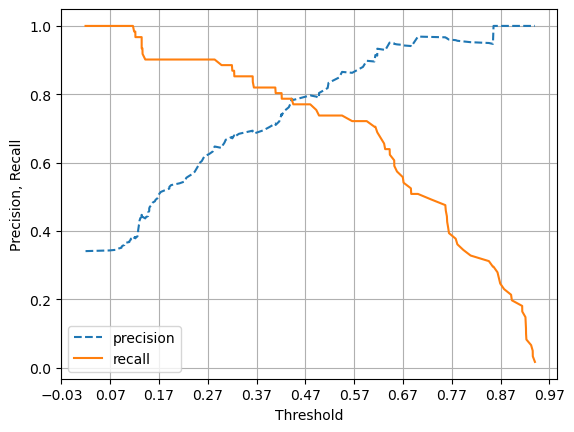

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_precision_recall_curve(y_test, proba_posi):
    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_posi)
    
    plt.figure()
    num_thresholds = thresholds.shape[0];
    
    plt.plot(thresholds, precisions[0:num_thresholds], linestyle='--', label="precision")
    plt.plot(thresholds, recalls[0:num_thresholds], label="recall")
    
    # options
    x_start, x_end = plt.xlim()
    plt.xticks(np.round(np.arange(x_start, x_end, 0.1), 2))
    
    plt.xlabel("Threshold");
    plt.ylabel("Precision, Recall");
    plt.legend();
    plt.grid();
    plt.show();
    
plot_precision_recall_curve(y_test, proba_posi)    

# evaluation: F1 score, ROC AUC

## F1 score

In [17]:
from sklearn.metrics import f1_score

In [18]:
f1_value = f1_score(y_test, predictions)
print(f"F1 score: {f1_value:.4F}")

F1 score: 0.7759


In [25]:
# redefine the evaluation function to include F1 score.
def evaluate(y_test, predictions):
    # confusion matrix
    print("confusion matrix:\n", confusion_matrix(y_test, predictions))
    
    # accuracy, precision & recall, F1 score
    print(f"accuracy : {accuracy_score(y_test, predictions):.4F}")
    print(f"precision: {precision_score(y_test, predictions):.4F}")
    print(f"recall   : {recall_score(y_test, predictions):.4F}")
    print(f"F1 score : {f1_score(y_test, predictions):.4F}")

    print("\n")

In [26]:
thresholds = np.arange(0.4, 0.65, 0.05)

proba_posi = proba[:, 1].reshape(-1, 1)
evaluate_for_each_threshold(y_test, proba_posi, thresholds)

threshold: 0.4
confusion matrix:
 [[98 20]
 [11 50]]
accuracy : 0.8268
precision: 0.7143
recall   : 0.8197
F1 score : 0.7634


threshold: 0.45
confusion matrix:
 [[106  12]
 [ 14  47]]
accuracy : 0.8547
precision: 0.7966
recall   : 0.7705
F1 score : 0.7833


threshold: 0.5
confusion matrix:
 [[108  10]
 [ 16  45]]
accuracy : 0.8547
precision: 0.8182
recall   : 0.7377
F1 score : 0.7759


threshold: 0.55
confusion matrix:
 [[111   7]
 [ 17  44]]
accuracy : 0.8659
precision: 0.8627
recall   : 0.7213
F1 score : 0.7857


threshold: 0.6
confusion matrix:
 [[113   5]
 [ 18  43]]
accuracy : 0.8715
precision: 0.8958
recall   : 0.7049
F1 score : 0.7890




## ROC AUC

In [27]:
from sklearn.metrics import roc_curve

In [37]:
proba_posi = proba[:, 1]  # probabilities when label is 1

fprs, tprs, thresholds = roc_curve(y_test, proba_posi)

# for some selected thresholds
threshold_indices = np.arange(1, thresholds.shape[0], 5)
print("selected thresholds:", np.round(thresholds[threshold_indices], 2))

print("TPRs:\n", np.round(tprs[threshold_indices], 3))
print("FPRs:\n", np.round(fprs[threshold_indices], 3))

selected thresholds: [0.94 0.7  0.62 0.57 0.44 0.36 0.32 0.15 0.13 0.13 0.12]
TPRs:
 [0.016 0.508 0.689 0.721 0.787 0.82  0.885 0.902 0.951 0.967 1.   ]
FPRs:
 [0.    0.008 0.025 0.059 0.11  0.195 0.22  0.534 0.61  0.746 0.831]


In [42]:
def plot_roc_curve(y_test, proba_posi):
    fprs, tprs, thresholds = roc_curve(y_test, proba_posi)

    plt.plot(fprs, tprs, label="ROC")
    plt.plot([0, 1], [0, 1], "k--", label="random")

    x_ini, x_fin = plt.xlim()
    plt.xticks(np.round(np.arange(x_ini, x_fin, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("FPR"); plt.ylabel("FPR")
    plt.legend()
    
    plt.show()

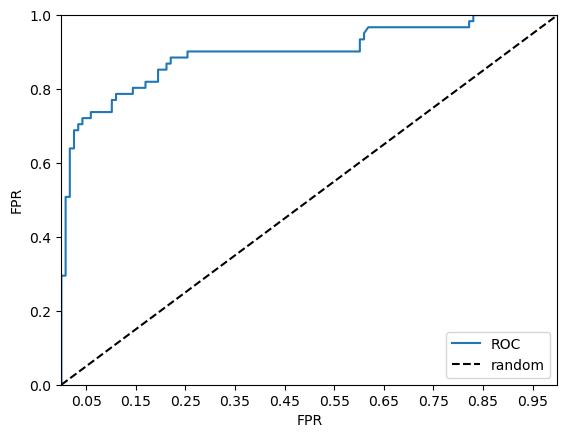

In [43]:
plot_roc_curve(y_test, proba_posi)

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_value = roc_auc_score(y_test, proba_posi)
print(f"ROC AUC score : {roc_auc_value:.4F}")

ROC AUC score : 0.8977


In [46]:
# redefine the evaluation function to include ROC AUC score.
def evaluate(y_test, predictions, proba_posi):
    # confusion matrix
    print("confusion matrix:\n", confusion_matrix(y_test, predictions))
    
    # accuracy, precision & recall, F1 score
    print(f"accuracy      : {accuracy_score(y_test, predictions):.4F}")
    print(f"precision     : {precision_score(y_test, predictions):.4F}")
    print(f"recall        : {recall_score(y_test, predictions):.4F}")
    print(f"F1 score      : {f1_score(y_test, predictions):.4F}")
    print(f"ROC AUC score : {roc_auc_score(y_test, proba_posi):.4F}")

    print("\n")

In [49]:
evaluate(y_test, predictions, proba_posi)

confusion matrix:
 [[108  10]
 [ 16  45]]
accuracy      : 0.8547
precision     : 0.8182
recall        : 0.7377
F1 score      : 0.7759
ROC AUC score : 0.8977


